$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 6: YOLO - Objects Detection
<a id=part6></a>

In this part we will use an object detection architecture called YOLO (You only look once) to detect objects in images. We'll use an already trained model weights (v5) found here: https://github.com/ultralytics/yolov5

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Load the YOLO model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")
model.to(device)
# Images
img1 = 'imgs/DolphinsInTheSky.jpg'  
img2 = 'imgs/cat-shiba-inu-2.jpg' 

Using cache found in /Users/galkesten/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-22 Python-3.8.12 torch-1.10.1 CPU

Fusing layers... 
[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Inference with YOLO
<a id=part6_1></a>

You are provided with 2 images (img1 and img2).
**TODO**:
1. Detect objects using the YOLOv5 model for these 2 images.
2. Print the inference output with bounding boxes.
3. Look at the inference results and answer the question below.


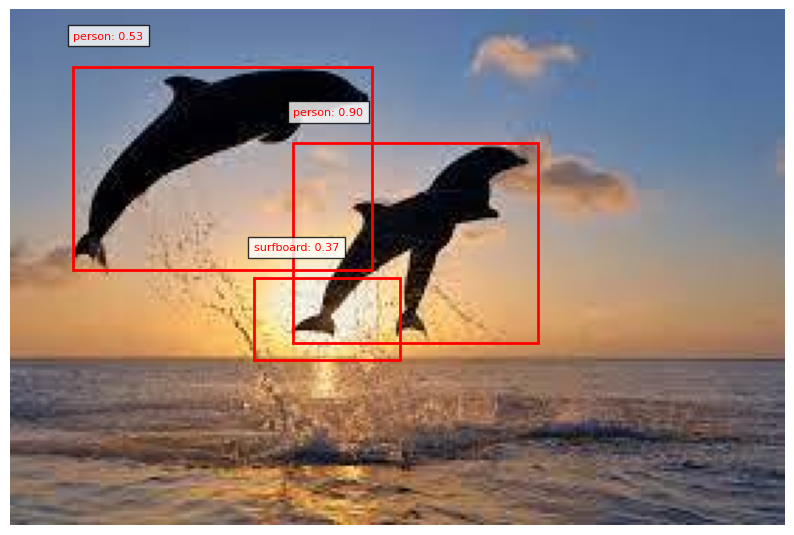

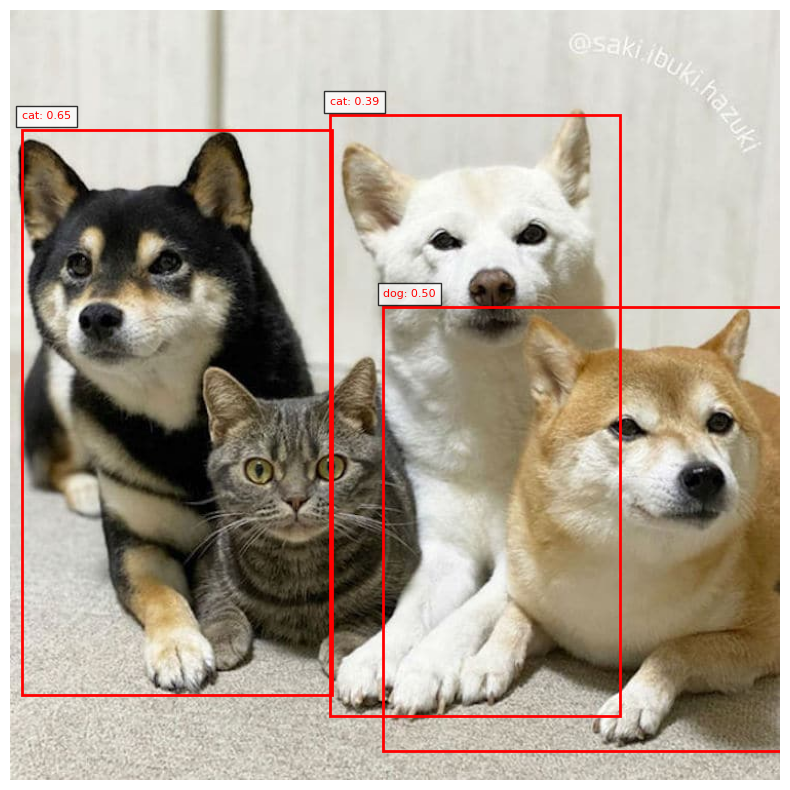

In [2]:
%matplotlib inline

import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

with torch.no_grad():
    imgs = [img1, img2]
    results = model(imgs)
    dfs = results.pandas().xyxy
    
    for i, df in enumerate(dfs):
        img = cv2.cvtColor(cv2.imread(imgs[i]), cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = img.shape
        
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        
        # Draw bounding boxes and labels
        for _, row in df.iterrows():
            xmin = int(row['xmin'])
            ymin = int(row['ymin'])
            xmax = int(row['xmax'])
            ymax = int(row['ymax'])
            label = f"{row['name']}: {row['confidence']:.2f}"
            
            # Draw bounding box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            plt.text(xmin, ymin - 10, label, color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.axis('off')
        plt.show()


In [3]:
from cs236781.answers import display_answer
import hw2.answers

### Question 1

Analyze the inference results of the 2 images. 
1. How well did the model detect the objects in the pictures? with what confidance?
2. What can possibly be the reason for the model failures? suggest methods to resolve that issue.
3. recall that we learned how to fool a model by adverserial attack (PGD), describe how you would attack an Object Detection model (such as YOLO).

In [4]:
display_answer(hw2.answers.part6_q1)



1.1

**Image 1**


**Localization Problem:**
There are actually three dolphins in the image.One dolphin is classified correctly.
Two of them are close together, which might have confused the model,
resulting in a single bounding box covering both dolphins. 
One of the dolphin's tail of the merged dolphins is detected as a separate object.

**Detection Performance:**

The detection performance is poor. The model incorrectly identified:
  - Two dolphins as "person" with confidence scores of $0.53$ and $0.90$.
  - The tail of a dolphin as a "surfboard" with a confidence score of $0.37$.

**Image 2**

**Localization:**
- The model localized three dogs but failed to detect one of the cats entirely.

**Detection Performance:**
- The model made the following predictions:
  - Two dogs were labeled as "cat" with confidence scores of $0.65$ and $0.39$.
  - The actual dog was labeled correctly but with a low confidence score of $0.50$.
- The model's predictions show confusion between cats and dogs, indicating issues with the classification performance.

1.2

**Failure Reasons for the First Image**
The model fails because "dolphin" is not a class in the YOLOv5 model's 
training data, causing it to mislabel the dolphins as other classes.
In addition, the low resolution and tricky lighting conditions at sunset might also influenced the .
the model ability to correctly identify and localize objects. 
It's likely that the model hasn't been trained on enough images in similar lighting conditions. 
Also, there might be a bias in the training data towards pictures of people surfing at sunset,
leading the model to wrongly label dolphins as people and surfboards. 
Regarding the problem of mislocalizing the two dolphins, 
it may be related to the black shadow that merges the objects, 
making it difficult for the model to distinguish between them.

**Failure Reasons for the Second Image**
In the second image, even though the resolution is better,
the model still struggles with classification. 
It confuses dogs for cats, probably because of the dogs' cat-like ear shapes and poses. 
This suggests that the model hasn't seen enough examples of these variations in the training data.
The poses of the dogs  also might be confusing the model,
causing these incorrect classifications.
Additionally, the model completely misses detecting one of the cats.
This could be due to how anchor boxes are used in YOLOv5.
YOLOv5 uses anchor boxes to predict bounding boxes around objects.
Anchor boxes are pre-defined boxes with specific heights and widths
that the model uses as a reference.
If these predefined anchor boxes don't match the sizes and shapes of the objects
in the image well, the model might have trouble detecting them.
This mismatch can lead to missed objects or inaccurate localization.
By optimizing these anchor boxes to better fit the objects in the training data,
the model's performance can be improved.

**Solutions to Address Model Issues**
To address these issues, we need to improve the training dataset with a wider variety of images.
This means adding more pictures of dolphins in different lighting conditions and dogs with 
various ear shapes and poses.
Using data augmentation techniques can also help make the training data more diverse.
For the first image, increasing the contrast between the two dolphins can help the model
distinguish them better. Additionally, optimizing anchor boxes by analyzing the dataset can
ensure they better match the size and shapes of the objects in the images.
This involves checking the training data to find the most common object sizes and
shapes and adjusting the anchor boxes accordingly.
Refining how the bounding boxes are set up can also help the model detect
and localize objects more accurately.
Using more bounding boxes per grid cell can also improve the detection of
objects with varying sizes and shapes, further enhancing the model's performance.
Finally, adding a custom class for dolphins and retraining the model with a more diverse and
comprehensive dataset would help in accurately detecting dolphins.

1.3

Using Projected Gradient Descent (PGD), we can generate adversarial examples that
target YOLO's loss.
The process involves adding small perturbations to the input image,
calculating the gradient of the targeted loss function (classification, confidence,
localization or combination of them), and iteratively
updating the perturbation to maximize the loss. By projecting the perturbed image back
into the valid input space to keep changes realistic, we create adversarial images that cause
the model to misclassify objects, alter bounding box coordinates, miss objects entirely,
or detect nonexistent objects. This method disrupts the model's performance while keeping
the adversarial changes imperceptible to human observers.


## Creative Detection Failures

<a id=part6_2></a>

Object detection pitfalls could be, for example: **occlusion** - when the objects are partially occlude, and thus missing important features, **model bias** - when a model learn some bias about an object, it could recognize it as something else in a different setup, and many others like **Deformation**, **Illumination conditions**, **Cluttered** or **textured background and blurring** due to moving objects.

**TODO**: Take pictures and that demonstrates 3 of the above object detection pitfalls, run inference and analyze the results.

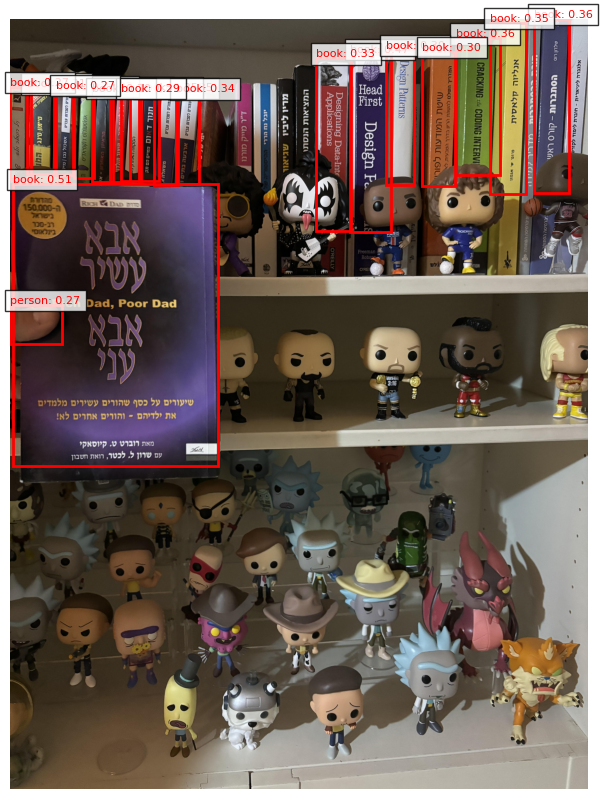

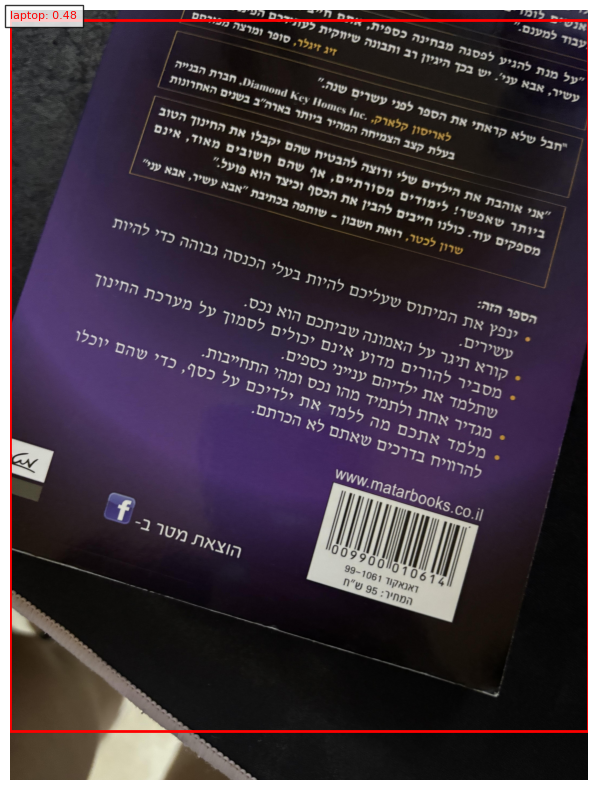

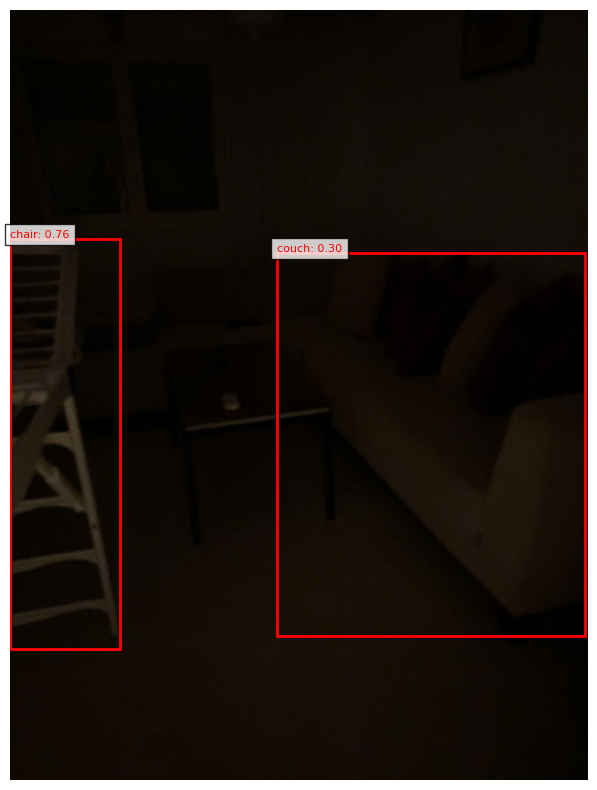

In [5]:
#Insert the inference code here.
%matplotlib inline

import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

with torch.no_grad():
    imgs = ['imgs/background.jpeg', 'imgs/partial.jpeg', 'imgs/dark.jpeg']
    results = model(imgs)
    dfs = results.pandas().xyxy
    
    for i, df in enumerate(dfs):
        img = cv2.cvtColor(cv2.imread(imgs[i]), cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = img.shape
        
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        
        # Draw bounding boxes and labels
        for _, row in df.iterrows():
            xmin = int(row['xmin'])
            ymin = int(row['ymin'])
            xmax = int(row['xmax'])
            ymax = int(row['ymax'])
            label = f"{row['name']}: {row['confidence']:.2f}"
            
            # Draw bounding box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='red', linewidth=2)
            plt.gca().add_patch(rect)
            plt.text(xmin, ymin - 10, label, color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
        
        plt.axis('off')
        plt.show()

### Question 3

Analyize the results of the inference. 
1. How well did the model detect the objects in the pictures? explain.


In [6]:
display_answer(hw2.answers.part6_q3)



**Picture 1: Cluttered Background**

**Description:** A cluttered bookshelf with many overlapping dolls and books.
**Inference Results:**
The detector identified 18 books and incorrectly identified a person’s hand as a person.
It failed to detect any of the dolls, likely due to the high number of objects and clutter.
Even among the books, some were missed, and the model's confidence in its detections was low.

**Picture 2: Partial Occlusion and Model Bias**

**Description:** A book is photographed at an angle with parts of it excluded.
**Inference Results:** The model misclassified the book as a laptop.
This indicates a bias where the model associates certain angles with laptops and expects books
to be in specific orientations and fully visible for correct classification.

**Picture 3: Illumination Conditions and Partial Occlusion**

**Description:** The image is taken in a dark room with poor lighting.
**Inference Results:** The detector failed to identify the table due to the poor lighting,
making it difficult to distinguish objects.
It misclassified the laundry hanger as a chair, likely because the model hasn't been trained on
laundry hangers. The couch was also poorly localized due to the lighting conditions.


## Bonus 
<a id=part6_3></a>

Try improving the model performance over poorly recognized images by changing them. 
Describe the manipulations you did to the pictures.

In [7]:
#insert bonus code here

In [8]:
display_answer(hw2.answers.part6_bonus)



**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

